# Analysis of confout.pdb files

This is to check progress of a certain bead through the simulation to be sure it's not drifting too far in one way. Ideally, you have all beads (or every other) for the entire string so far (so for 200 iterations, a 200 frame simulation)

You use `per_bead_confout.sh` to get the input file for this

In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

In [47]:
indir = '../confout_files/measure_per_bead'
#traj = 'efflux_demyst_CV'
traj = 'influx_BFRU_demyst_CV'

bead = 25

u = mda.Universe('%s/%s.bead_%i.string.pdb' %(indir, traj, bead))



/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


# Gate COM detection
This is an adaptation of the EC plots in the per_iteration_analysis, but principal is the same

Adding a line of best fit can show if there is a concerning trend in a direction


In [48]:
from MDAnalysis.analysis import distances

def make_gate_arr(md_uni, gate_EC, gate_IC):
    gate_EC_dists = []
    gate_IC_dists = []
    
    for timestep in md_uni.trajectory:
        tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
        tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
        tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
        tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    


        gate_EC_dists.append(float(distances.distance_array(tm1, tm7)))
        gate_IC_dists.append(float(distances.distance_array(tm4, tm10)))

    return gate_EC_dists, gate_IC_dists

In [49]:
def make_gate_plot(EC, IC, label_list, figname = None, line_of_best_fit = None):
    figsize = (13, 6)
    markersize = 8
    linewidth = 1
    lim = (8,17)
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, figsize = figsize)

    ## ec gate
    ax1.plot(EC, label = 'Bead %s' %bead, color = color, linewidth = linewidth)
    ax1.set_title("Extracellular gate")
    ax1.set_xlim(0)
    ax1.set_ylabel('Distance (A)')


    ## ic gate
    ax2.plot(IC, label = "Bead %s" %bead, color = color, linewidth = linewidth)
    ax2.set_title("Intracellular gate")
    ax2.set_xlim(0) 
    ax2.set_xlabel('Iteration #')
    ax2.set_ylabel('Distance (A)')

    
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
              fancybox=True, shadow=True, ncol=2)

    
    if line_of_best_fit:
        iterations = np.arange(0, len(EC))
        m, b = np.polyfit(iterations, EC, 1)
        ax1.plot(iterations, m*iterations + b, linewidth = linewidth*2)
        
        m, b = np.polyfit(iterations, IC, 1)
        ax2.plot(iterations, m*iterations + b, linewidth = linewidth*2)
          
    
    if figname:
        plt.savefig('../images_figs/%s.png' %figname, dpi = 200)

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:690: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


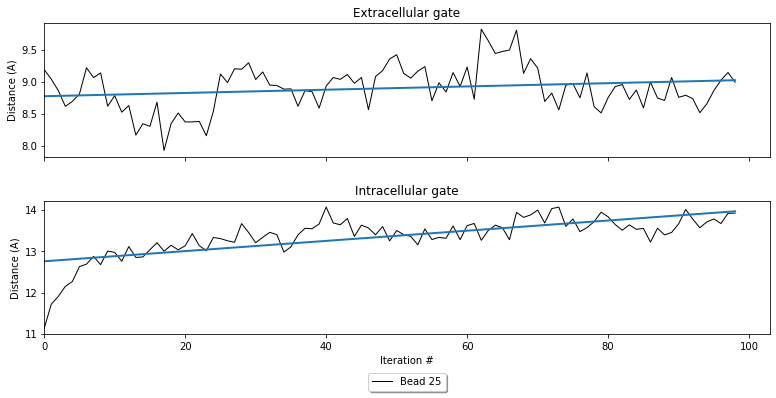

In [50]:
color = 'black'


EC, IC = make_gate_arr(u, gate_EC = [(30,37), (289,295)], gate_IC = [(136,145), (386,394)])


make_gate_plot(EC = EC, IC = IC, label_list = iterations, line_of_best_fit = True)

# RMSD of protein
Always good to check

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py:865: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


Text(0, 0.5, 'RMSD (A)')

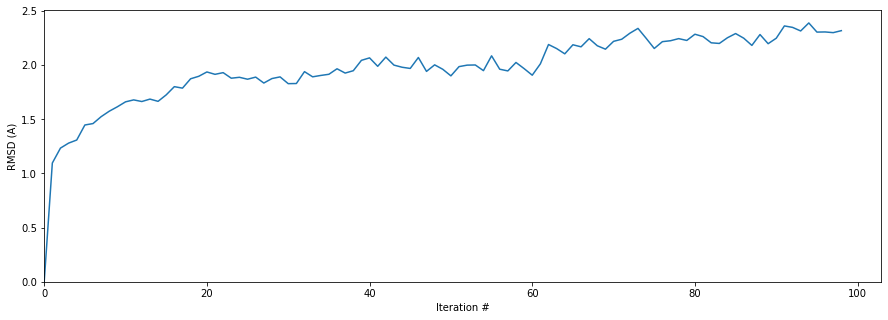

In [58]:
import MDAnalysis.analysis.rms

RMSD = MDAnalysis.analysis.rms.RMSD(u, center = True)
RMSD.run(0)

rmsd = RMSD.rmsd.T
time = rmsd[1]
fig = plt.figure(figsize = (15,5))
plt.plot(rmsd[2])
plt.xlim(0)
plt.ylim(0)

plt.xlabel('Iteration #')
plt.ylabel('RMSD (A)')